Taller 3

Camilo Castillo Lasso

201412050

In [ ]:
%pylab inline
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import os
from scipy import ndimage

"cp1242"

In [2]:
# Datos Llantas tractivas 
rll=0.139 # Radio geométrico de las llantas en traseras (m)
refc=0.98*rll # Radio efectivo llantas traseras (m)
rin=0.0631 #radio interno del neumático (m)

# Datos Transmisión
dp=11.0 # Dientes del piñon
dpl=87.0 # Dientes del plato
ng=1.9 # Relación de Transmisión
etaf=0.95 # Eficiencia de transmisión

# Datos eje llantas
reje=0.02 # Radio eje de las llantas (m)
meje=3.832 # Masa del eje (kg)

# Datos Kart general
masa=140.0 # masa del Kart con piloto(kg)
g=9.81 # Gravedad (m/s)
w=masa*g # peso del Kart (N)

# Datos Fuerzas de la fórmula de aceleración
rho=1.1955 # densidad del aire (kg/m^3)
dll=0.975 # Distancia entre ejes de llantas delanteras (m)
alj=0.88 # Altura con el piloto sentado en el kart (estatura 1.68 m) (m)
af=(dll*alj)/2 # Area Frontal Kart (m^2)
cd=0.89 # Coeficiente de Arrastre Kart
vw=0.0 # velocidad del viento (m/s)
theta=0.0 # Angulo carretera

# Inercias
ii=0.01 # Inercia motor de combustión 

mllt=1.43 # Masa llantas traseras (kg)
mlld=1.20 # Masa llantas delanteras (kg)
rlld=0.129 # Radio llantas delanteras (m)
rind=0.0631 # Radio rin llantas delanteras (m)
mbt=0.7*mllt # El porcentaje de la masa total que pesa la parte "banda" de la llanta trasera
mdt=0.3*mllt # El porcentaje de la masa total que pesa la parte "disco" de la llanta trasera
mbd=0.7*mlld # El porcentaje de la masa total que pesa la parte "banda" de la llanta delantera
mdd=0.3*mlld # El porcentaje de la masa total que pesa la parte "disco" de la llanta delantera
illd=(mbd*rlld)+(mdd*(rlld**2-rind**2))/2 # Inercia 1 llanta delantera (kg-m^2)
illt=(mbt*rll)+(mdt*(rll**2-rin**2))/2 # Inercia 1 llanta trasera (kg-m^2)
illTotal=2*illd+illt*2

rpi=0.01525 # Radio Piñon (m)
rpla=0.10775 # Radio Plato (m)
rhoac=7850.0 # Densidad del Acero (kg/m^3)
bpi=0.01 # Ancho piñon (m)
bpla=0.01 # Ancho plato (m)
vpi= bpi*np.pi*rpi**2 # Volumen del piñon (m^3)
vpla=bpla*np.pi*rpla**2 # Volumen del plato (m^3)
mpi=rhoac*vpi # Masa del piñon (kg)
mpla=rhoac*vpla # Masa del plato (kg)
ig=((mpi*(rpi**2))/2)+((mpla*(rpla**2))/2) # Inercia de la transmisión (kg-m^2)

ieje=(meje*reje**2)/2 # Inercia del eje de las llantas (kg-m^2)

# Fuerzas Aceleración
# Resistencia a la rodadura
a=0.2036 # Distancia del centro de gravedad al eje de la llanta trasera (m)
l=1.0063 # Distancia de eje de las llantas traseras y delanteras (m)
h=0.0960 # Altura del centro de gravedad del kart con respecto al piso (m)
masa_eq=((illTotal)+(ieje)+(ii*ng**2))/refc**2
def accel(vx, ddt):
    return ndimage.gaussian_filter1d(vx, sigma=20, order=1, mode='wrap') / ddt

def frodadura(vx,ax):
    wr=w*((a/l)+(ax/g*(h/l))) # fuerza vertical sobre las llantas tractivas
    fr=0.01*(1+(vx/100.0)) # Factor de rodadura la velocidad del kart debe estar en (km/h)

    return wr*fr*cos(theta) # (N)

# Fuerza del ángulo de la carretera
def finclinacion(theta):
    return w*sin(theta) # (N)

# Fuerza de arrastre
def farrastre(vx):
    return (1/2.0)*rho*af*cd*(vx+vw)**2 # (N)

# Fuerza de tracción, Torque del Motor
def ftraccion(ax,Fg,Fw,Fr):
    # Ft=((ti*ng*etaf)/refc)-(((ii-ig)*ng^2)+ieje+illd*2+illt*2)*(ax/(refc^2)) # (N)
    return masa*ax+Fg+Fw+Fr

def TorqueMotor(a_i,v_i):
    T=(masa+masa_eq)*a_i+frodadura(v_i,a_i)+farrastre(v_i)
    T=T*refc/(ng-etaf)
    if T<0:
        T=0
    return T
# Aceleración, Fuerza de tracción
# mr=(((ii-ig)*ng^2)+ieje+illd*2+illt*2)/(refc^2) 
# ax=(((ti*ng*etaf)/refc)-Fg-Fw-Fr)/(m+mr) # (m/s)

# Velocidad angular del motor
def vAngularMotor(vx):
    a=(vx*ng)/refc
    if a<(50*(2*pi)/60):
        a=50*(2*pi)/60
    if a>(5000*(2*pi)/60):
        a=5000*(2*pi)/60
    return a # (rad/s)

In [3]:
def importVBoxNuevo(tipoEnergia,nombre): #tipoEnergia=(electrico,combustion)
    direccion='data_'+tipoEnergia
    nombreArchivo=nombre
    datosCompleto=pd.read_table(os.path.join(direccion,nombreArchivo),sep="\s+",header=61, 
                                names=["sats","time","lat","long","velocity","heading","height","longacc","latacc","temp","Vbat","batt-flags","batt-ai","batt.soc"])
    datosDef=datosCompleto.drop(["longacc","latacc","temp","Vbat","batt-flags","batt-ai","batt.soc"],axis=1)
    return datosDef

In [4]:
def importVBoxViejo(tipoEnergia,nombre): #tipoEnergia=(electrica,combustion)
    direccion='data_'+tipoEnergia
    nombreArchivo=nombre
    datosCompleto=pd.read_table(os.path.join(direccion,nombreArchivo),sep="\s+",header=26)
    datosDef=datosCompleto.drop(["vert-vel","pot","event-1"],axis=1)
    return datosDef

In [5]:
ini=4000
nPuntos=1861 # para VBS__052.VBO
#ini=345
#nPuntos=1195 # para VBS__047.VBO

def corteDatosElectrico(x):
    a=[]
    fin=ini+nPuntos
    for i,v in enumerate (x):
        if i>=ini:
            if i<=fin:
                a.append(v)
    return asarray(a)

In [6]:
inic=3000
nPuntosc=6950 # para VBOX0020.VBO
#inic=0
#nPuntosc=5475 #VBOX0024.VBO
#inic=7560
#nPuntosc=6020 #VBOX0024.VBO
def corteDatosCombustion(x):
    a=[]
    fin=inic+nPuntosc
    for i,v in enumerate (x):
        if i>=ini:
            if i<=fin:
                a.append(v)
    return asarray(a)

In [7]:
def derivacionNumerica(vel,time):
    a=[]
    dt=time[1]-time[0]
    for i,v in enumerate (vel):
        if i<(len(vel)-1):
            acel=(vel[i+1]-vel[i])/dt
            a.append(acel)
    return a

In [8]:

def graficarDesempeño(tipoEnergia,nombre):

    if tipoEnergia is 'electrico':
        datos=importVBoxNuevo(tipoEnergia,nombre)
        time0=corteDatosElectrico(array(datos['time']))
        lat0=corteDatosElectrico(array(datos['lat']))
        long0=corteDatosElectrico(array(datos['long']))
        vel0=corteDatosElectrico(array(datos['velocity']))/3.6 
    if tipoEnergia is 'combustion':
        datos=importVBoxViejo(tipoEnergia,nombre)
        time0=corteDatosCombustion(array(datos['time']))
        lat0=corteDatosCombustion(array(datos['lat']))
        long0=corteDatosCombustion(array(datos['long']))
        vel0=corteDatosCombustion(array(datos['velocity']))/3.6 

    
    torque=[]
    velAngular=[]
    potencia=[]
    
    time_base=time0[0]
    time0=time0-time_base
    lat0=lat0/60
    long0=long0/60
    acel0=derivacionNumerica(vel0,time0)
    for i,a in enumerate (acel0):
        
        torque.append(TorqueMotor(acel0[i],vel0[i]))
        velAngular.append(vAngularMotor(vel0[i]))
        P=TorqueMotor(acel0[i],vel0[i])*vAngularMotor(vel0[i])/1000
        potencia.append(P)
    potencia=array(potencia)
    return time0,lat0,long0,vel0,acel0,torque,velAngular,potencia

    

    

In [9]:


def graficarMapa(lat,long,time):
    #posicion
    plt.figure(1)
    plt.title('Mapa')
    plt.axis('off')
    plt.plot(long,lat,'g')
    plt.annotate('Inicio',xy=(long[0],lat[0]),arrowprops=dict(facecolor='black',shrink=0.05))


In [10]:
def graficarVel(lat,long,vel):
    #velocidad
    plt.figure(2)
    plt.scatter(long,lat,c=vel,cmap='OrRd')
    plt.xlim([min(long)-0.0001,max(long)+0.0001])
    plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Velocidad[$m/s$]')
    plt.annotate('Inicio',xy=(long[0],lat[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    

In [11]:
def graficarAcel(lat,long,acel):
    #aceleracion
    plt.figure(3)
    long00=[]
    lat00=[]
    for i,t in enumerate(long):
        if i<len(long)-1:
            long00.append(long[i])
            lat00.append(lat[i])
    long00=np.array(long00)
    lat00=np.array(lat00)
    plt.scatter(long00,lat00,c=acel,cmap='cool')
    plt.xlim([min(long)-0.0001,max(long)+0.0001])
    plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Aceleracion[$m/s^2$]')
    plt.annotate('Inicio',xy=(long[0],lat[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
   

In [12]:
def graficarTorque(lat,long,torque):
    #Torque
    plt.figure(4)
    long00=[]
    lat00=[]
    for i,t in enumerate(long):
        if i<len(long)-1:
            long00.append(long[i])
            lat00.append(lat[i])
    long00=np.array(long00)
    lat00=np.array(lat00)
    plt.scatter(long00,lat00,c=torque,cmap='BrBG')
    plt.xlim([min(long)-0.0001,max(long)+0.0001])
    plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Torque Motor[Nm]')
    plt.annotate('Inicio',xy=(long[0],lat[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    

In [13]:
def graficarVelAngular(lat,long,velAngular):
    #velocidad angular motor
    plt.figure(5)
    long00=[]
    lat00=[]
    for i,t in enumerate(long):
        if i<len(long)-1:
            long00.append(long[i])
            lat00.append(lat[i])
    long00=np.array(long00)
    lat00=np.array(lat00)
    plt.scatter(long00,lat00,c=velAngular,cmap='Oranges')
    plt.xlim([min(long)-0.0001,max(long)+0.0001])
    plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Velocidad Angular Motor[$rad/s$]')
    plt.annotate('Inicio',xy=(long[0],lat[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    

In [14]:
def graficarPotencia(lat,long,potencia):
        #Potencia motor
    plt.figure(6)
    long00=[]
    lat00=[]
    for i,t in enumerate(long):
        if i<len(long)-1:
            long00.append(long[i])
            lat00.append(lat[i])
    long00=np.array(long00)
    lat00=np.array(lat00)
    plt.scatter(long00,lat00,c=potencia,cmap='bwr')
    plt.xlim([min(long)-0.0001,max(long)+0.0001])
    plt.ylim([min(lat)-0.0001,max(lat)+0.0001])
    plt.axis('off')
    plt.xlabel('Longitud')
    plt.ylabel('Latitud')
    plt.title('Potencia Motor[KW]')
    plt.annotate('Inicio',xy=(long[0],lat[0]),arrowprops=dict(facecolor='black',shrink=0.05))
    plt.colorbar()
    plt.show()
    

In [29]:
def graficarPerformace(tipo,nombre):
    time,lat,long,vel,acel,torque,velAngular,potencia=graficarDesempeño(tipo,nombre)
    graficarMapa(lat,long,time)
    graficarVel(lat,long,vel)
    graficarAcel(lat,long,acel)
    graficarTorque(lat,long,torque)
    graficarVelAngular(lat,long,velAngular)
    graficarPotencia(lat,long,potencia)

    
    print('El tiempo de vuelta fue:'+str(max(time))+'s')
    print('La velocidad Maxima y promedio fue:'+str(max(vel))+'m/s, '+str(mean(vel))+'m/s')
    print('La aceleracion Maxima fue:'+str(max(acel))+'m/s^2, '+str(mean(acel))+'m/s^2')
    print('El torque Maximo fue:'+str(max(torque))+'Nm, '+str(mean(torque))+'Nm')
    print('La velocidad angular Maxima fue:'+str(max(velAngular))+'rad/s, '+str(mean(velAngular))+'rad/s')
    print('La potencia Maxima fue:'+str(max(potencia))+'KW, '+str(mean(potencia))+'KW')

Desempeño del motor electrico


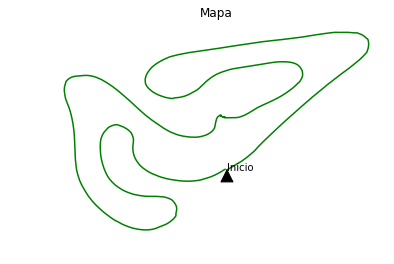

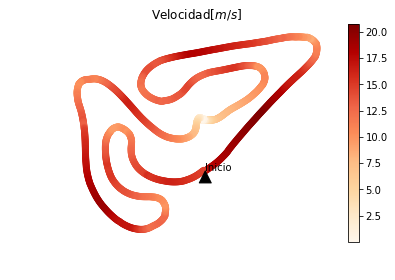

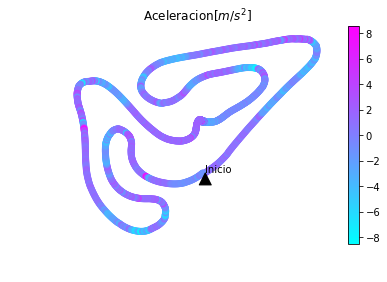

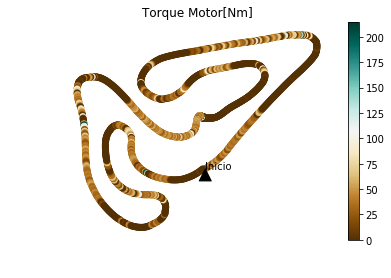

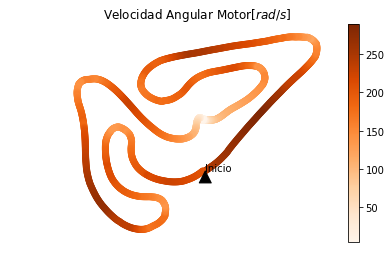

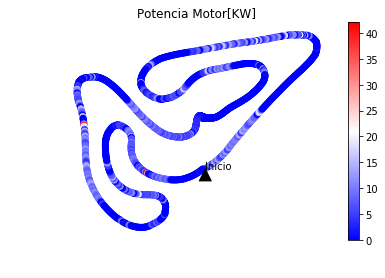

El tiempo de vuelta fue:480.4s
La velocidad Maxima y promedio fue:20.6916666667m/s, 10.6243913355m/s
La aceleracion Maxima fue:8.55555555755m/s^2, -0.0283897546188m/s^2
El torque Maximo fue:214.307316768Nm, 20.8843111625Nm
La velocidad angular Maxima fue:288.607889199rad/s, 148.573800032rad/s
La potencia Maxima fue:42.0473769549KW, 3.51106810941KW


In [33]:
print('Desempeño del motor electrico')
graficarPerformace('electrico','VBS__052.VBO')

Desempeño del motor combustion


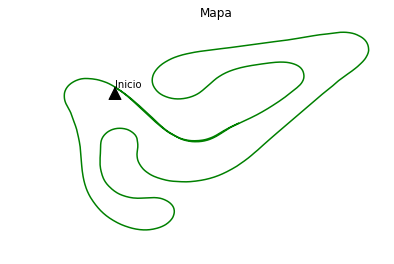

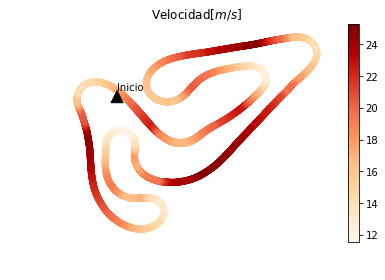

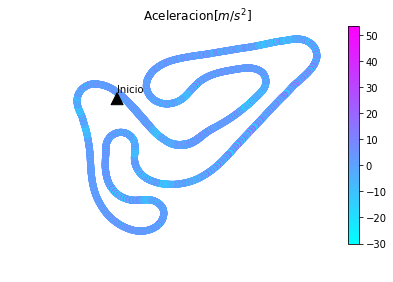

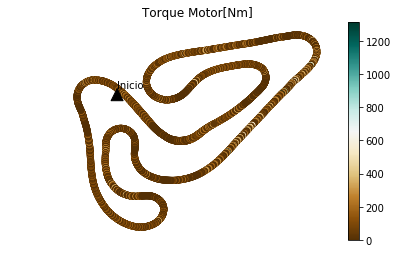

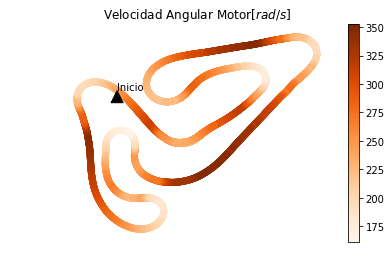

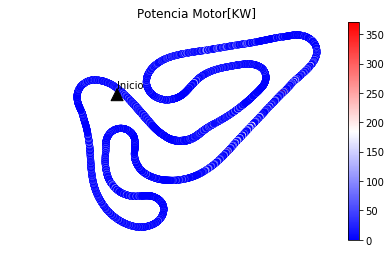

El tiempo de vuelta fue:99.5s
La velocidad Maxima y promedio fue:25.2686111111m/s, 18.2335596725m/s
La aceleracion Maxima fue:53.472222328m/s^2, 0.0524743231664m/s^2
El torque Maximo fue:1312.87261849Nm, 66.4616862431Nm
La velocidad angular Maxima fue:352.447225893rad/s, 254.317466795rad/s
La potencia Maxima fue:370.034258021KW, 17.1667956282KW


In [34]:
print('Desempeño del motor combustion')
graficarPerformace('combustion','VBOX0020.VBO')

Comparando las series de datos obtenidas para ambos tipos de motores podemos observar que en principio el tiempo que emplea el kart con motor a combustion es menos de 4 veces el tiempo que emplea el kart con motor electrico en dar una vuelta a la pista.

Adicionalmente podemos notar que la velocidad promedio del kart a combustion es casi el doble de la velocidad del kart electrico

Notese que la aceleracion promedio del kart electrico es negativa.